### 16.3 使用PyTorch实现图像修复
	近些年，深度学习在图像修复（Image Inpainting）领域取得重大进展，方法很多，但基本原理类似。本节介绍一种基于编码器与解码器网络结构的图像修复方法。

### 16.3.1 网络结构
	该网络结构称为上下文编码器（Context Encoder），主要由编码器-解码器构成。不过编码器与解码器之间不是通常的全连接层，而是采用与通道等宽的全连接层（Channel-wise fully-connected layer），利用这种网络层可大大降低参数量。此外，还有一个对抗判别器，用来区分预测值与真实值，这个与生成式对抗网络的判别器功能类似，具体网络结构如图16-12 所示。

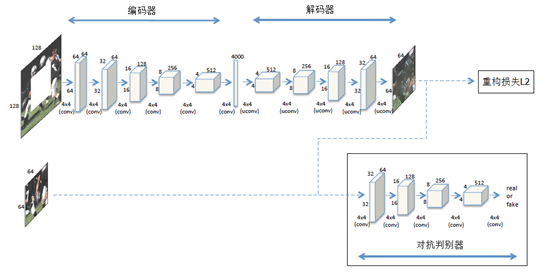
<center>图16-12 上下文编码器-解码器架构</center>
	其中解码器基于AlexNet网络，五个卷积加上池化，如果输入图像为227x227，可以得到一个6x6x256的特征图。解码器就是一系列的五个上卷积的操作，使其恢复到与原图一样的大小。
	该网络之所以称为上下文是因为采用了语言处理中根据上下文预测的原理，这里采用被损坏周围的图像特征来预测被损坏的部分。如何学习到被损坏的特征？这就涉及下节将介绍的损失函数。

### 16.3.2 损失函数
整个模型的损失值由重构损失（Reconstruction Loss）与对抗损失（Adversarial Loss）组成。重构损失的计算公式为：
 $$ \mathcal L_{rec}(χ)=|| M ̂\odot(χ-F((1- M ̂)\odotχ)) ||_2^2 \tag{61-1} $$ 
其中⨀为逐元操作，M ̂为缺失图像的二进制掩码，1表示缺失部分像素，0表示输入像素。如果只有重构损失，修复的图像比较模糊，为解决这个问题，可增加一个对抗损失。
	可以从多种可能的输出模式中选择一种对抗损失，换句话说，可以进行特定模式选择，使得预测结果看起来更真实。对抗损失的计算公式为：
 $$\mathcal L_{adv}=\underset{D}{max} ⁡E_{x∈χ} [log⁡(D(x))+log⁡(1-D(F((1-M ̂ )\odot x)))] \tag{61-2} $$   
	总的损失函数为重构损失与对抗损失的加权值。
 $$ \mathcal L= λ_{rec}\mathcal L_{rec}+ λ_{adv} \mathcal L_{adv}  \tag{61-3} $$  

### 16.3.3 图像修复实例
	为了给大家一个直观理解，这里我们使用一个预训练模型来实现图像修复，该预训练模型是基于大量街道数据训练得到的。

In [1]:
import argparse
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
parser = argparse.ArgumentParser(description='Process some params')
parser.add_argument('--dataset',  default='streetview', help='cifar10 | lsun | imagenet | folder | lfw ')
parser.add_argument('--test_image', default='./data/001_im.png',required=False, help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=4)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--imageSize', type=int, default=128, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--nc', type=int, default=3)
parser.add_argument('--niter', type=int, default=50, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='../data/netG_streetview.pth', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')

parser.add_argument('--nBottleneck', type=int,default=4000,help='of dim for bottleneck of encoder')
parser.add_argument('--overlapPred',type=int,default=4,help='overlapping edges')
parser.add_argument('--nef',type=int,default=64,help='of encoder filters in first conv layer')
parser.add_argument('--wtl2',type=float,default=0.999,help='0 means do not use else use with this weight')
opt = parser.parse_args(['--dataset', 'streetview'])
print(opt)

Namespace(batchSize=64, beta1=0.5, cuda=False, dataset='streetview', imageSize=128, lr=0.0002, manualSeed=None, nBottleneck=4000, nc=3, ndf=64, nef=64, netD='', netG='../data/netG_streetview.pth', ngf=64, ngpu=1, niter=50, nz=100, outf='.', overlapPred=4, test_image='./data/001_im.png', workers=4, wtl2=0.999)


In [3]:
print(opt.dataset, opt.test_image)

streetview ./data/001_im.png


In [4]:
import torch
from PIL import Image


def load_image(filename, size=None, scale=None):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img



def save_image(filename, data):
    img = data.clone().add(1).div(2).mul(255).clamp(0, 255).cpu().numpy()
    #img = img.transpose(1, 2, 0).astype("uint8")
    img = img.transpose(1, 2, 0).astype(np.uint8)
    img = Image.fromarray(img)
    img.save(filename)


In [5]:
class netG(nn.Module):
    def __init__(self, opt):
        super(netG, self).__init__()
        #ngpu表示gpu个数，如果大于1，将使用并发处理
        self.ngpu = opt.ngpu
        self.main = nn.Sequential(
            # 输入通道数opt.nc，输出通道数为opt.nef
            nn.Conv2d(opt.nc,opt.nef,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.nef,opt.nef,4,2,1, bias=False),
            nn.BatchNorm2d(opt.nef),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.nef,opt.nef*2,4,2,1, bias=False),
            nn.BatchNorm2d(opt.nef*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.nef*2,opt.nef*4,4,2,1, bias=False),
            nn.BatchNorm2d(opt.nef*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.nef*4,opt.nef*8,4,2,1, bias=False),
            nn.BatchNorm2d(opt.nef*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.nef*8,opt.nBottleneck,4, bias=False),
            # tate size: (nBottleneck) x 1 x 1
            nn.BatchNorm2d(opt.nBottleneck),
            nn.LeakyReLU(0.2, inplace=True),
            #后面采用转置卷积，opt.ngf为该层输出通道数
            nn.ConvTranspose2d(opt.nBottleneck, opt.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(opt.ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(opt.ngf * 8, opt.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 4),
            nn.ReLU(True),            
            nn.ConvTranspose2d(opt.ngf * 4, opt.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 2),
            nn.ReLU(True),            
            nn.ConvTranspose2d(opt.ngf * 2, opt.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf),
            nn.ReLU(True),            
            nn.ConvTranspose2d(opt.ngf, opt.nc, 4, 2, 1, bias=False),
            nn.Tanh()            
        )

    def forward(self, input):
        if isinstance(input.detach(), torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [6]:
netG = netG(opt)
#加载预训练模型，其存放路径为opt.netG
netG.load_state_dict(torch.load(opt.netG,map_location=lambda storage, location: storage)['state_dict'])
netG.eval()

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


#加载测试图像
image = load_image(opt.test_image, opt.imageSize)
image = transform(image)
image = image.repeat(1, 1, 1, 1)

In [7]:
input_real = torch.FloatTensor(1, 3, opt.imageSize, opt.imageSize)
input_cropped = torch.FloatTensor(1, 3, opt.imageSize, opt.imageSize)
real_center = torch.FloatTensor(1, 3, opt.imageSize//2, opt.imageSize//2)

criterionMSE = nn.MSELoss()

In [8]:
input_cropped.shape

torch.Size([1, 3, 128, 128])

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netG.to(device)
input_real, input_cropped = input_real.to(device),input_cropped.to(device)
criterionMSE.to(device)
real_center = real_center.to(device)

In [10]:
input_cropped.detach().resize_(image.size()).copy_(image)
real_center_cpu = image[:,:,opt.imageSize//4:opt.imageSize//4+opt.imageSize//2,opt.imageSize//4:opt.imageSize//4+opt.imageSize//2]
real_center.detach().resize_(real_center_cpu.size()).copy_(real_center_cpu)

tensor([[[[ 0.1294,  0.0824,  0.0039,  ...,  0.0431,  0.0667,  0.0588],
          [ 0.0824,  0.0824,  0.0431,  ...,  0.0431,  0.0353,  0.1137],
          [-0.1059, -0.1137, -0.1216,  ..., -0.1294, -0.1294, -0.0353],
          ...,
          [-0.1686, -0.1059, -0.3412,  ..., -0.7333, -0.7490, -0.7961],
          [-0.2314, -0.2078, -0.3961,  ..., -0.7725, -0.7882, -0.7176],
          [-0.3255, -0.3569, -0.5843,  ..., -0.7725, -0.7490, -0.8353]],

         [[ 0.1529,  0.1137,  0.0431,  ...,  0.0510,  0.0667,  0.0667],
          [ 0.0902,  0.0980,  0.0667,  ...,  0.0902,  0.0667,  0.0980],
          [-0.1216, -0.1137, -0.1137,  ..., -0.1294, -0.1451, -0.0745],
          ...,
          [-0.1608, -0.1137, -0.3098,  ..., -0.8039, -0.8039, -0.8275],
          [-0.2392, -0.2314, -0.3961,  ..., -0.8431, -0.8353, -0.7333],
          [-0.3569, -0.3490, -0.5686,  ..., -0.7882, -0.7647, -0.7882]],

         [[ 0.1137,  0.0667, -0.0118,  ...,  0.0196,  0.0353,  0.0275],
          [ 0.0353,  0.0431, -

In [11]:
input_cropped.data[:,0,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred] = 2*117.0/255.0 - 1.0
input_cropped.data[:,1,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred] = 2*104.0/255.0 - 1.0
input_cropped.data[:,2,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred] = 2*123.0/255.0 - 1.0


In [12]:
fake = netG(input_cropped)
errG = criterionMSE(fake,real_center)

In [13]:
recon_image = input_cropped.clone()
recon_image.data[:,:,opt.imageSize//4:opt.imageSize//4+opt.imageSize//2,opt.imageSize//4:opt.imageSize//4+opt.imageSize//2] = fake.data


In [14]:
save_image('val_real_samples.png',image[0])
save_image('val_cropped_samples.png',input_cropped.data[0])
save_image('val_recon_samples.png',recon_image.data[0])
print('%.4f' % errG.item())

0.1058


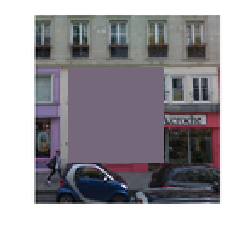

In [17]:
reconsPath = 'val_cropped_samples.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

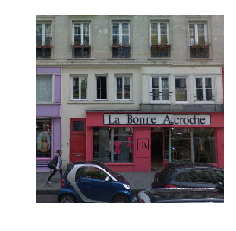

In [18]:
reconsPath = './data/001_im.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

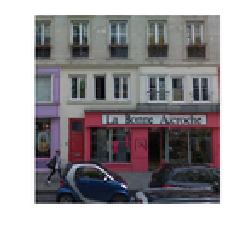

In [16]:
reconsPath = 'val_real_samples.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

### 修复后的图像

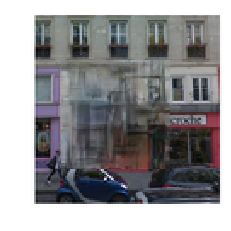

In [15]:
reconsPath = 'val_recon_samples.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()
